# Coursework 2 - Part 1

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Classification with a Convolutional Neural Network <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
- [Task 2](#task-2): Dimensionality Reduction: PCA vs ISOMAP <a name="index-task-2"></a>
  - [(2.1)](#task-21)
  - [(2.2)](#task-22)
  - [(2.3)](#task-23)  



---



In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from scipy.sparse import linalg

# Importing losses, activation functions and layers from PyTorch
from torch.nn import Sequential, CrossEntropyLoss, Conv2d, MaxPool2d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

# Changing default font sizes
plt.rc('xtick', labelsize=8) # Tick labels
plt.rc('ytick', labelsize=8) # Tick labels
plt.rc('legend', fontsize=10) # Legend
plt.rc('axes', titlesize=15, labelsize=10) # Title and 'x' and 'y' labels

In this coursework, we will work with a dataset of **images of stars** measured with the Euclid telescope of the European Space Agency. The training dataset comprises 648 images of stars (32 x 32 pixels) and the test set includes 32 images of stars (32 x 32 pixels). The stars in the dataset belong to **four stellar classes: O5V, A0V, F5V and M5V**. The first letter in the code denotes the spectral type (from hottest to coolest: O, B, A, F, G, K, M); the second digit represents the spectral subtype (from hottest to coolest: 1-9); the third letter V indicates that all the stars in our dataset are dwarf stars.

<a name="task-1"></a>

# (1) Task 1: Classification with a Convolutional Neural Network [(index)](#index-task-1)

This task is about training a **Convolutional Neural Network (CNN)** to classify the star images into the 4 classes.

We load the training and testing datasets.

In [199]:
X = np.load('star_images_train.npy')
y = np.load('star_classes_train.npy')

X_test = np.load('star_images_test.npy')
y_test = np.load('star_classes_test.npy')

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

We split the training dataset in two parts: 75% for the actual training and 25% for the validation set.

In [200]:
split_rate = 0.75
np.random.seed(0)
indices = np.random.choice(np.arange(X.shape[0]), size=int(split_rate * X.shape[0]), replace=False)
X_train = X[indices]
y_train = y[indices]

val_indices = list(set(np.arange(X.shape[0])) - set(indices))
X_val = X[val_indices]
y_val = y[val_indices]

# Verify the shape of the sets
data_shapes = pd.DataFrame({'Set' : ['X', 'y', 'X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test'],
                        'Shape' : [X.shape, len(y), X_train.shape, len(y_train), X_val.shape, len(y_val), X_test.shape, len(y_test)]})

print(data_shapes.to_string(index=False))

    Set         Shape
      X (648, 32, 32)
      y           648
X_train (486, 32, 32)
y_train           486
  X_val (162, 32, 32)
  y_val           162
 X_test  (32, 32, 32)
 y_test            32


We plot a randomly selected example from each class.

In [93]:
fig = plt.figure(figsize=(185, 110))
n = 221
classes = np.sort(np.unique(y_train))

for label in classes:
    inx = np.where(y_train == label)[0]
    i = np.random.choice(inx)
    fig.add_subplot(n)
    plt.xlabel('Pixel Index', size=100)
    plt.ylabel('Pixel Index', size=100)
    plt.title(f'Raw image n°{i} of class {label}', size=100)
    plt.imshow(X[i].reshape(32,32))
    n += 1

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=100)
plt.show()

We now build in `get_model()` the following CNN model:

* A first `Conv2d()` layer with 4 filters, kernel size of 5 and a `ReLU()` activation function
* A `MaxPool2d()` layer with a pooling window size of 2 and a stride of 2
* A second `Conv2d()` layer with 8 filters, kernel size of 5 and a `ReLU()` activation function
* A `Flatten()` layer
* A `Linear()` layer with 4 neurons and a `Softmax()` activation

The function below builds and compiles this model, using an `Adam` optimiser and a `CrossEntropyLoss` criterion.

In [94]:
def get_model(x_train, classes):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool2d, Conv2d(+ReLU), Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.

    Parameters:
    x_train: Training data.
    classes: List containing the output classes.

    Returns:
    Model, criterion and optimiser.
    """

    H_out_conv_1 = x_train.shape[1] - 5 + 1 # Heigh after first Conv2d
    W_out_conv_1 = x_train.shape[2] - 5 + 1 # Width after first Conv2d
    print(f'Shape after second convolution: ({H_out_conv_1},{W_out_conv_1})')

    H_out_pool = (H_out_conv_1 - 2) // 2 + 1 # Heigh after Pool2d
    W_out_pool = (W_out_conv_1 - 2) // 2 + 1 # Width after Pool2d
    print(f'Shape after max-pool: ({H_out_pool},{W_out_pool})')

    H_out_conv_2 = (H_out_pool - 5 + 1) # Heigh after second Conv2d
    W_out_conv_2 = (W_out_pool - 5 + 1) # Width after second Conv2d
    print(f'Shape after second convolution: ({H_out_conv_2},{W_out_conv_2})')

    l_in_linear = 8 * H_out_conv_2 * W_out_conv_2 # Size before Linear layer
    print(f'Shape after flattening: {l_in_linear}')

    model = Sequential(
        Conv2d(in_channels=1, out_channels=4, kernel_size=5),
        ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(in_channels=4, out_channels=8, kernel_size=5),
        ReLU(),
        Flatten(),
        Linear(l_in_linear, len(classes)),
        Softmax(dim=1),
    )

    criterion = CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters())

    return model, criterion, optimiser

We get the model and print it:

In [206]:
model_cnn, criterion_cnn, optimiser_cnn = get_model(X_train, classes)
print('\nModel:\n')
print(model_cnn)

Shape after second convolution: (28,28)
Shape after max-pool: (14,14)
Shape after second convolution: (10,10)
Shape after flattening: 800

Model:

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=800, out_features=4, bias=True)
  (7): Softmax(dim=1)
)


Now we are ready to train the model. The `training_loop()` function runs the training for `max_num_epochs` of 2000 and `batch_size` of 128, featuring early stopping to monitor the validation accuracy. The `max_patience` parameter is set to 150 epochs. The function returns the training and validation history, which includes the loss and accuracy.

In [202]:
# Numpy arrays to PyTorch tensors
X_train_tensor = (torch.tensor(X_train, dtype=torch.float32)).unsqueeze(1)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = (torch.tensor(X_val, dtype=torch.float32)).unsqueeze(1)
y_val_tensor = torch.tensor(y_val)
X_test_tensor = (torch.tensor(X_test, dtype=torch.float32)).unsqueeze(1)

# Creating training and validation datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [97]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:
            self.best_valid_loss = val_loss
            self.patience = 0
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [98]:
def training_loop(model, criterion, optimiser, train_loader, val_loader, max_num_epochs=2000, max_patience=150, print_epoch=False):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class
    print_epoch: Bool for printing or not each epoch result

    Returns:
    Model, criterion and optimiser.

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)

    epochs_bar = tqdm(range(max_num_epochs))

    for epoch in epochs_bar:

        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            tr_loss += loss.item()
            tr_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)

        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += (torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0))

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Calculate accuracy and print
        if print_epoch:
            print(f"Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_accuracy}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_accuracy}%")

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping acting.")
            break

    return history

We call the training loop:

In [207]:
max_num_epochs = 2000
max_patience = 150

history = training_loop(model_cnn, criterion_cnn, optimiser_cnn, train_loader, val_loader, max_num_epochs, max_patience)

  0%|          | 0/2000 [00:00<?, ?it/s]

We plot the learning curves:

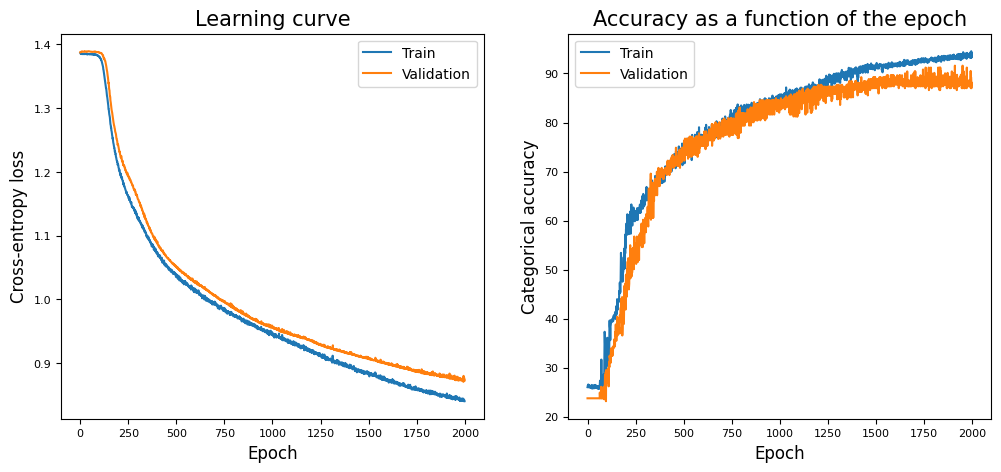

The training accuracy is: 94.13679534313727
The validation accuracy is: 87.77573529411764


In [208]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

print('The training accuracy is:', history['training_accuracy'][-1])
print('The validation accuracy is:', history['validation_accuracy'][-1])

**Analysis:** On the first plot, we observe the training convergence. During the first hundred epochs, the cross-entropy loss, for both the train and validation sets, does not decrease that much; the model is in the process of learning and adjusting its weights. Next, between around 150 and 250 epochs the loss decreases significantly; the model starts to learn more effectively (it starts to capture important patterns in the data). It then continues to decrease but the rate of decrease slows down until the last epoch: the model approaches an optimal solution. However, as expected, we notice that the training set's cross-entropy loss decreases more than that of the validation set, resulting in cross-entropy losses of below 0.9 for both.  
For the size of our data, the traning convergence seems to be really reasonable and converges to a small cross-entropy loss in a rational number of epochs.

We evaluate the model's classification accuracy on the test set:

In [209]:
# Get the model predictions on the test set
preds = model_cnn(X_test_tensor).detach().numpy()
preds_class = np.argmax(preds, axis=1)

# Compute accuracy of the model on the set
accuracy = (preds_class == y_test).sum() / len(y_test)

print('Truth: ', y_test)
print('Preds: ', preds_class)
print(f'\nAccuracy on Test set: {100*accuracy}%')

Truth:  [3 3 3 3 1 1 2 2 3 2 0 1 0 1 2 3 0 2 0 3 0 1 1 3 1 2 2 1 0 0 2 0]
Preds:  [3 3 3 3 1 1 2 2 3 2 0 1 1 2 2 3 0 2 0 3 0 1 1 3 1 2 2 2 0 0 2 0]

Accuracy on Test set: 90.625%


**Analysis:** Our model obtains a 90.63% classification accuracy on the test set. Such a score is noteworthy, and suggest that our model generalises well to unseen data. However, the small number of images (32 images) in the test set might be a limitation. Indeed, with a bigger test set, we could more confidently evaluate the model's accuracy and ensure that the result would be really representative of its performances. Nonetheless, the above result shows really promising performances of our model.



---



<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

We add $L_2$ regularisation to both 2-dimensional convolutional layers.

We build the new CNN model in `get_model_reg()` (a slightly modified version of `get_model()`):

* A first `Conv2d()` layer with 4 filters, kernel size of 5 and a `ReLU()` activation function
    * This layer uses $L_2$ weight regularisation
* A `MaxPool2d()` layer with a pooling window size of 2 and a stride of 2
* A second `Conv2d()` layer with 8 filters, kernel size of 5 and a `ReLU()` activation function
    * This layer uses $L_2$ weight regularisation
* A `Flatten()` layer
* A `Linear()` layer with 4 neurons and a `Softmax()` activation



In [3]:
def get_model_reg(x_train, classes, l2_reg):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool2d, Conv2d(+ReLU), Flatten and Linear(+Softmax).
    - Both 2-dimensional convolutional layers have L2 regularisation.
    - It features an Adam optimiser and CrossEntropyLoss criterion.

    Parameters:
    x_train: Training data.
    classes: List containing the output classes.
    l2_reg: Positive float corresponding to the regularisation coefficient of Conv2d.

    Returns:
    Model_reg, criterion_reg and optimiser_reg.
    """

    H_out_conv_1 = x_train.shape[1] - 5 + 1 # Heigh after first Conv2d
    W_out_conv_1 = x_train.shape[2] - 5 + 1 # Width after first Conv2d

    H_out_pool = (H_out_conv_1 - 2) // 2 + 1 # Heigh after Pool2d
    W_out_pool = (W_out_conv_1 - 2) // 2 + 1 # Width after Pool2d

    H_out_conv_2 = (H_out_pool - 5 + 1) # Heigh after second Conv2d
    W_out_conv_2 = (W_out_pool - 5 + 1) # Width after second Conv2d

    l_in_linear = 8 * H_out_conv_2 * W_out_conv_2 # Size before Linear layer

    model_reg = Sequential(
        Conv2d(in_channels=1, out_channels=4, kernel_size=5),
        ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(in_channels=4, out_channels=8, kernel_size=5),
        ReLU(),
        Flatten(),
        Linear(l_in_linear, len(classes)),
        Softmax(dim=1),
    )

    # L2 regularisation
    for layer in model_reg.children():
        if isinstance(layer, Conv2d):
            layer.weight_regularizer = Parameter(l2_reg * torch.ones_like(layer.weight))

    def l2_regularisation(outputs, labels):
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(outputs, labels)

        penalty_term = 0.
        for layer in model_reg.children():
            if isinstance(layer, Conv2d):
                penalty_term += torch.sum(layer.weight_regularizer * (layer.weight ** 2))

        loss += penalty_term

        return loss


    criterion_reg = l2_regularisation
    optimiser_reg = torch.optim.Adam(model_reg.parameters())

    return model_reg, criterion_reg, optimiser_reg

We use the classification accuracy on the validation set to find the optimal penalty coefficient for the   regularisation by scanning over values 0.001, 0.01, 0.1, 1, and 10.

For l2_reg=0.001


  0%|          | 0/2000 [00:00<?, ?it/s]

For l2_reg=0.01


  0%|          | 0/2000 [00:00<?, ?it/s]

For l2_reg=0.1


  0%|          | 0/2000 [00:00<?, ?it/s]

For l2_reg=1


  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping acting.
For l2_reg=10


  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping acting.


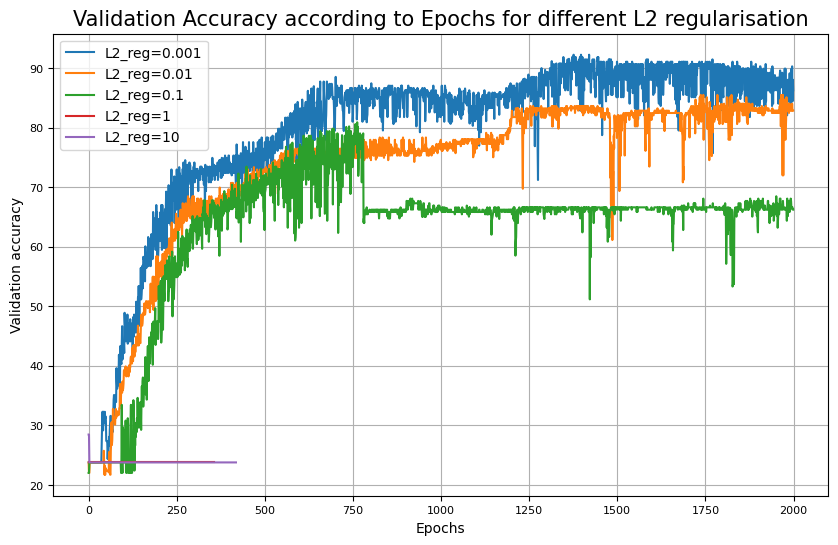

The optimal l2 regularisation coefficient is 0.001.


In [160]:
max_num_epochs = 2000
max_patience = 150

l2_values = [0.001, 0.01, 0.1, 1, 10]
val_scores = []

plt.figure(figsize=(10, 6))

for l2reg in l2_values:
    print(f'For l2_reg={l2reg}')
    model_reg, criterion_reg, optimiser_reg = get_model_reg(X_train, classes, l2_reg=l2reg)
    history_l2reg = training_loop(model_reg, criterion_reg, optimiser_reg, train_loader, val_loader, max_num_epochs, max_patience)
    val_scores.append(history_l2reg['validation_accuracy'][-1])
    plt.plot(history_l2reg['validation_accuracy'], label=f'L2_reg={l2reg}')

plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('Validation Accuracy according to Epochs for different L2 regularisation')
plt.legend()
plt.grid()
plt.show()

l2reg_opti_index = np.argmax(val_scores)
l2reg_opti = l2_values[l2reg_opti_index]

print(f'The optimal l2 regularisation coefficient is {l2reg_opti}.')

Using the obtained optimal $L_2$ regularisation coefficient, we re-train the CNN on the training set and evaluate the classification accuracy on the test set.

In [161]:
# Build and train the model with optimal L2 regularisation coefficient
model_reg, criterion_reg, optimiser_reg = get_model_reg(X_train, classes, l2_reg=l2reg_opti)
history = training_loop(model_reg, criterion_reg, optimiser_reg, train_loader, val_loader, max_num_epochs, max_patience)

# Get the model predictions on the test set
preds_reg = model_reg(X_test_tensor).detach().numpy()
preds_class_reg = np.argmax(preds_reg, axis=1)

# Compute accuracy of the model on the set
accuracy_reg = (preds_class_reg == y_test).sum() / len(y_test)

print('Truth: ', y_test)
print('Preds: ', preds_class_reg)
print(f'\nAccuracy on Test set: {100*accuracy_reg}%')

  0%|          | 0/2000 [00:00<?, ?it/s]

Truth:  [3 3 3 3 1 1 2 2 3 2 0 1 0 1 2 3 0 2 0 3 0 1 1 3 1 2 2 1 0 0 2 0]
Preds:  [3 3 3 3 1 1 2 2 3 2 0 1 0 1 2 3 0 2 0 3 0 1 2 3 1 2 2 1 0 2 2 0]

Accuracy on Test set: 93.75%


**Analysis:** Our model obtains a 93.75% classification accuracy on the test set. Such a score is really noteworthy, and suggest that our model generalises well to unseen data. Besides, we observe that the model seems to perform slightly better with $L_2$ regularisation, compared to _Task 1.1_.   
Once again, the small number of images (32 images) in the test set might be a limitation. Indeed, with a bigger test set, we could more confidently evaluate the model's accuracy and ensure that the result would be really representative of its performances. Nonetheless, the above result shows promising performances of our model.



---



<a name="task-13"></a>

## (1.3) [(index)](#index-task-12)

We will now gauge the sensitivity of the CNN to class imbalance. Then, we will test strategies to mitigate class imbalance: reweighted loss function and a strategy based on data augmentation, i.e., producing additional training data.

First, we create an imbalanced training set by randomly dropping half of the data points in class 3 (M5V) from the original training set, and split the resulting dataset into 75% for actual training and 25% for validation.

In [172]:
# Create imbalance
class_3_indices = np.where(y == 3)[0]
np.random.seed(0)
remove_class_3_indices = np.random.choice(class_3_indices, size=int(len(class_3_indices) / 2), replace=False)

X_imb = np.delete(X, remove_class_3_indices, 0)
y_imb = np.delete(y, remove_class_3_indices)


# Split
split_rate = 0.75
np.random.seed(0)
split_indices = np.random.choice(np.arange(X_imb.shape[0]), size=int(split_rate * X_imb.shape[0]), replace=False)

X_train_imb = X_imb[split_indices]
y_train_imb = y_imb[split_indices]

val_split_indices = list(set(np.arange(X_imb.shape[0])) - set(split_indices))
X_val_imb = X_imb[val_split_indices]
y_val_imb = y_imb[val_split_indices]

# Verify the shape of the sets
data_shapes_imb = pd.DataFrame({'Set' : ['X', 'y', 'Class 3', 'X_imb', 'y_imb', 'X_train_imb', 'y_train_imb', 'X_val_imb', 'y_val_imb', 'X_test', 'y_test'],
                        'Shape' : [X.shape, len(y), len(class_3_indices), X_imb.shape, len(y_imb), X_train_imb.shape, len(y_train_imb), X_val_imb.shape, len(y_val_imb), X_test.shape, len(y_test)]})

print(data_shapes_imb.to_string(index=False))

        Set         Shape
          X (648, 32, 32)
          y           648
    Class 3           161
      X_imb (568, 32, 32)
      y_imb           568
X_train_imb (426, 32, 32)
y_train_imb           426
  X_val_imb (142, 32, 32)
  y_val_imb           142
     X_test  (32, 32, 32)
     y_test            32


We re-train the CNN from _Task 1.1_ on this imbalanced training set, and we plot training and validation accuracies during training. Finally, we report the accuracy on the test set of this re-trained CNN model.

In [173]:
# Numpy arrays to PyTorch tensors
X_train_imb_tensor = (torch.tensor(X_train_imb, dtype=torch.float32)).unsqueeze(1)
y_train_imb_tensor = torch.tensor(y_train_imb)
X_val_imb_tensor = (torch.tensor(X_val_imb, dtype=torch.float32)).unsqueeze(1)
y_val_imb_tensor = torch.tensor(y_val_imb)

# Creating training and validation datasets
train_dataset_imb = TensorDataset(X_train_imb_tensor, y_train_imb_tensor.squeeze())
val_dataset_imb = TensorDataset(X_val_imb_tensor, y_val_imb_tensor.squeeze())

# Creating corresponding DataLoaders
train_imb_loader = DataLoader(train_dataset_imb, batch_size=128, shuffle=True)
val_imb_loader = DataLoader(val_dataset_imb, batch_size=128, shuffle=False)

In [174]:
model_imb, criterion_imb, optimiser_imb = get_model(X_train_imb, classes)
print('\nModel:\n')
print(model_imb)

Shape after second convolution: (28,28)
Shape after max-pool: (14,14)
Shape after second convolution: (10,10)
Shape after flattening: 800

Model:

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=800, out_features=4, bias=True)
  (7): Softmax(dim=1)
)


In [108]:
max_num_epochs = 2000
max_patience = 150

history_imb = training_loop(model_imb, criterion_imb, optimiser_imb, train_imb_loader, val_imb_loader, max_num_epochs, max_patience)

  0%|          | 0/2000 [00:00<?, ?it/s]

We plot the learning curves:

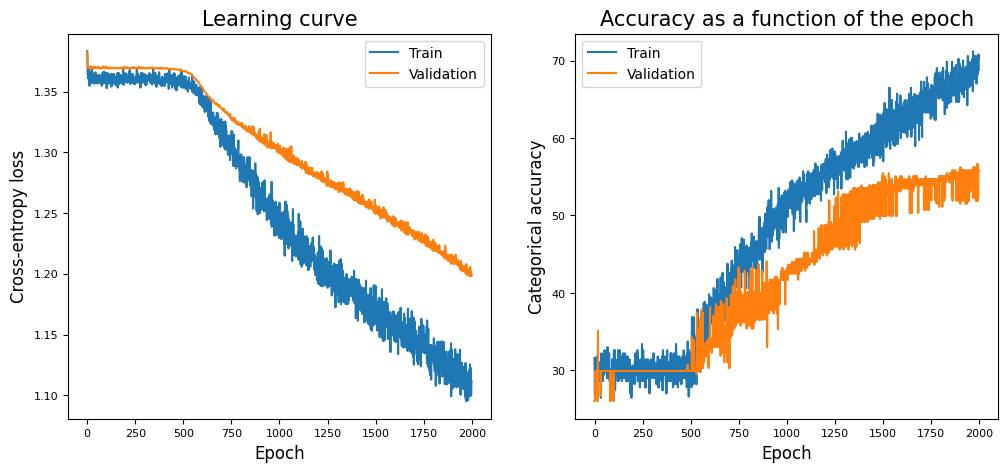

The training accuracy is: 68.81510416666666
The validation accuracy is: 55.859375


In [164]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_imb['training_loss'], label='Train')
plt.plot(history_imb['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_imb['training_accuracy'], label='Train')
plt.plot(history_imb['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

print('The training accuracy is:', history_imb['training_accuracy'][-1])
print('The validation accuracy is:', history_imb['validation_accuracy'][-1])

**Analysis:** As expected, the performance of our model on imbalanced data is significantly worse that in _Task 1.1_. The traning convergence is less effective, only converging to a cross-entropy loss of about 1.1 for the training set and 1.20 for the validation set after 2000 epochs. Moreover, the model's accuracies on the training and validation sets are much lower, with final accuracies of around 70% and 55%, respectively.

In [167]:
# Get the model predictions on the test set
preds_imb = model_imb(X_test_tensor).detach().numpy()
preds_class_imb = np.argmax(preds_imb, axis=1)

# Compute accuracy of the model on the set
accuracy_imb = (preds_class_imb == y_test).sum() / len(y_test)

print('Truth: ', y_test)
print('Preds: ', preds_class_imb)
print(f'\nAccuracy on Test set: {100*accuracy_imb}%')

Truth:  [3 3 3 3 1 1 2 2 3 2 0 1 0 1 2 3 0 2 0 3 0 1 1 3 1 2 2 1 0 0 2 0]
Preds:  [2 2 2 2 1 0 2 2 2 2 0 1 1 1 2 2 0 1 0 2 0 1 1 2 1 2 2 2 0 0 1 0]

Accuracy on Test set: 59.375%


**Analysis:** As expected, the test accuracy of only 59.38% is much lower with imbalanced data, which is pretty low. It suggests that our model does not handle well imbalanced data. We need to mitigate class imbalance in order to improve the model's accuracy.

Let's test two strategies to mitigate class imbalance.

For the first strategy, we modify the CNN loss function so that class 3 (the minority class) has more weight, choosing an appropriate reweighting strategy: $weight_{class} = \frac{1}{class\_size}$. We train the CNN from _Task 1.1_ with this reweighted loss, plotting the training and validation accuracies during training.

In [111]:
def get_model_weighted(x_train, classes, weights):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool2d, Conv2d(+ReLU), Flatten and Linear(+Softmax).
    - It features an Adam optimiser and weighted CrossEntropyLoss criterion.

    Parameters:
    x_train: Training data.
    classes: List containing the output classes.
    weights: Weights of each class.

    Returns:
    Model_weighted, criterion_weighted and optimiser_weighted.
    """

    H_out_conv_1 = x_train.shape[1] - 5 + 1 # Heigh after first Conv2d
    W_out_conv_1 = x_train.shape[2] - 5 + 1 # Width after first Conv2d

    H_out_pool = (H_out_conv_1 - 2) // 2 + 1 # Heigh after Pool2d
    W_out_pool = (W_out_conv_1 - 2) // 2 + 1 # Width after Pool2d

    H_out_conv_2 = (H_out_pool - 5 + 1) # Heigh after second Conv2d
    W_out_conv_2 = (W_out_pool - 5 + 1) # Width after second Conv2d

    l_in_linear = 8 * H_out_conv_2 * W_out_conv_2 # Size before Linear layer

    model_weighted = Sequential(
        Conv2d(in_channels=1, out_channels=4, kernel_size=5),
        ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(in_channels=4, out_channels=8, kernel_size=5),
        ReLU(),
        Flatten(),
        Linear(l_in_linear, len(classes)),
        Softmax(dim=1),
    )

    criterion_weighted = CrossEntropyLoss(weight = weights) # Add weights
    optimiser_weighted = torch.optim.Adam(model_weighted.parameters())

    return model_weighted, criterion_weighted, optimiser_weighted

In [175]:
class_0 = np.where(y_train_imb == 0)[0]
class_1 = np.where(y_train_imb == 1)[0]
class_2 = np.where(y_train_imb == 2)[0]
class_3 = np.where(y_train_imb == 3)[0]

weights = np.array([1 / len(class_x) for class_x in [class_0, class_1, class_2, class_3]]) # Weights as defined above
torch_weights = torch.tensor(weights, dtype=torch.float32)

model_weighted, criterion_weighted, optimiser_weighted = get_model_weighted(X_train_imb, classes, torch_weights)
print('Model:\n')
print(model_weighted)

Model:

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=800, out_features=4, bias=True)
  (7): Softmax(dim=1)
)


In [113]:
history_weighted = training_loop(model_weighted, criterion_weighted, optimiser_weighted, train_imb_loader, val_imb_loader, max_num_epochs, max_patience)

  0%|          | 0/2000 [00:00<?, ?it/s]

We plot the learning curves:

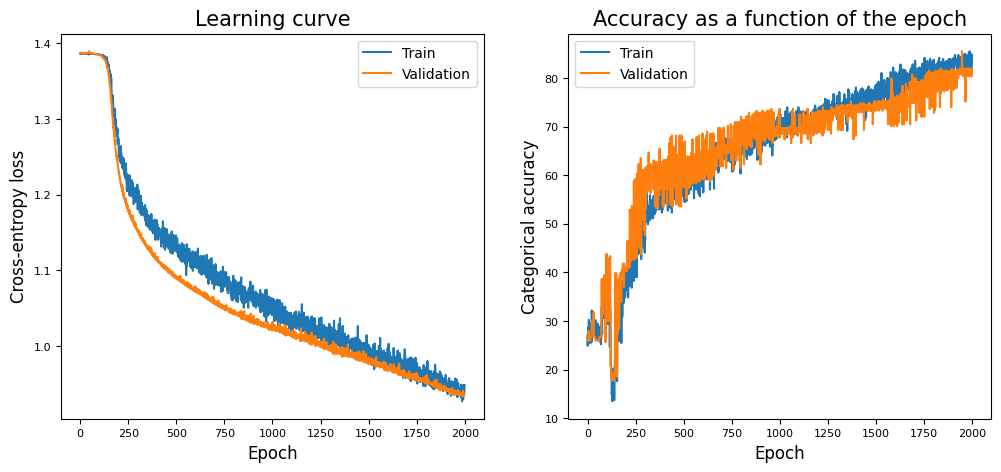

The training accuracy is: 81.54761904761905
The validation accuracy is: 81.52901785714286


In [168]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_weighted['training_loss'], label='Train')
plt.plot(history_weighted['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_weighted['training_accuracy'], label='Train')
plt.plot(history_weighted['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

print('The training accuracy is:', history_weighted['training_accuracy'][-1])
print('The validation accuracy is:', history_weighted['validation_accuracy'][-1])

**Analysis:** We observe a significant improvement in the model's performance after applying the reweighting strategy. The training convergence for both the training and validation sets is much more reasonable and even tends to be similar to that in _Task 1.1_. Additionaly, the accuracies around 80% for both training and validation sets are much more acceptable.

Let's analyse the test accuracy:

In [169]:
# Get the model predictions on the test set
preds_weighted = model_weighted(X_test_tensor).detach().numpy()
preds_class_weighted = np.argmax(preds_weighted, axis=1)

# Compute accuracy of the model on the set
accuracy_weighted = (preds_class_weighted == y_test).sum() / len(y_test)

print('Truth: ', y_test)
print('Preds: ', preds_class_weighted)
print(f'\nAccuracy on Test set: {100*accuracy_weighted}%')

Truth:  [3 3 3 3 1 1 2 2 3 2 0 1 0 1 2 3 0 2 0 3 0 1 1 3 1 2 2 1 0 0 2 0]
Preds:  [3 3 3 3 1 1 2 2 3 2 0 1 1 2 2 3 0 2 0 3 0 2 0 3 1 2 2 2 0 0 2 0]

Accuracy on Test set: 84.375%


**Analysis:** Once again, we observe a significant improvement in the model's performance after applying the reweighting strategy. An accuracy score of 84.38% is way more acceptable and even tends to be similar to that in _Task 1.1_. It suggests that our reweighted model generalises pretty well to unseen data. The reweighting stratety appears to be a reasonable strategy.

For the second strategy, we re-balance the training data, by producing new training data of the minority class (Class 3) using each image in the depleted class 3 to obtain an additional training image by adding Gaussian noise on each pixel drawn from the Gaussian distribution $\mathcal{N}$:  

$$
\text{Noise on pixel }p \sim\mathcal{N}(0,c\sigma^2_p),
$$

where c is a hyper-parameter to optimise and $\sigma^2_p$ is the variance of the value of pixel $p$ calculated across the images in the depleted class 3.

In [176]:
def augmented_data(X_imb, y_imb, X_depleted_class_3, y_depleted_class_3, c):
    variance_matrix = np.var(X_depleted_class_3, axis=0)
    noise = c * np.random.normal(scale=variance_matrix, size=X_depleted_class_3.shape)

    X_class_3_noise = X_depleted_class_3 + noise

    X_balanced = np.vstack((X_imb, X_class_3_noise))
    y_balanced = np.concatenate((y_imb, y_depleted_class_3))

    return X_balanced, y_balanced

In [182]:
depleted_class_3_indices = np.where(y_imb == 3)[0]

X_depleted_class_3 = (X_imb[depleted_class_3_indices, :]).copy()
y_depleted_class_3 = (y_imb[depleted_class_3_indices]).copy()
print(f'The represented classes in y_depleted_class_3 are: {np.unique(y_depleted_class_3)}\n')

X_balanced, y_balanced = augmented_data(X_imb, y_imb, X_depleted_class_3, y_depleted_class_3, c=0.1)

# Verify the shape of the sets
data_shapes_imb = pd.DataFrame({'Set' : ['X', 'y', 'Class 3', 'X_imb', 'y_imb', 'X_balanced', 'y_balanced'],
                        'Shape' : [X.shape, len(y), len(class_3_indices), X_imb.shape, len(y_imb), X_balanced.shape, len(y_balanced)]})

print(data_shapes_imb.to_string(index=False))

The represented classes in y_depleted_class_3 are: [3]

       Set         Shape
         X (648, 32, 32)
         y           648
   Class 3           161
     X_imb (568, 32, 32)
     y_imb           568
X_balanced (649, 32, 32)
y_balanced           649


We use the validation set accuracy to find an optimal value for $c$ by scanning over the values 0.01, 0.1 and 1.

For c=0.01
Shape after second convolution: (28,28)
Shape after max-pool: (14,14)
Shape after second convolution: (10,10)
Shape after flattening: 800


  0%|          | 0/2000 [00:00<?, ?it/s]

For c=0.1
Shape after second convolution: (28,28)
Shape after max-pool: (14,14)
Shape after second convolution: (10,10)
Shape after flattening: 800


  0%|          | 0/2000 [00:00<?, ?it/s]

For c=1
Shape after second convolution: (28,28)
Shape after max-pool: (14,14)
Shape after second convolution: (10,10)
Shape after flattening: 800


  0%|          | 0/2000 [00:00<?, ?it/s]

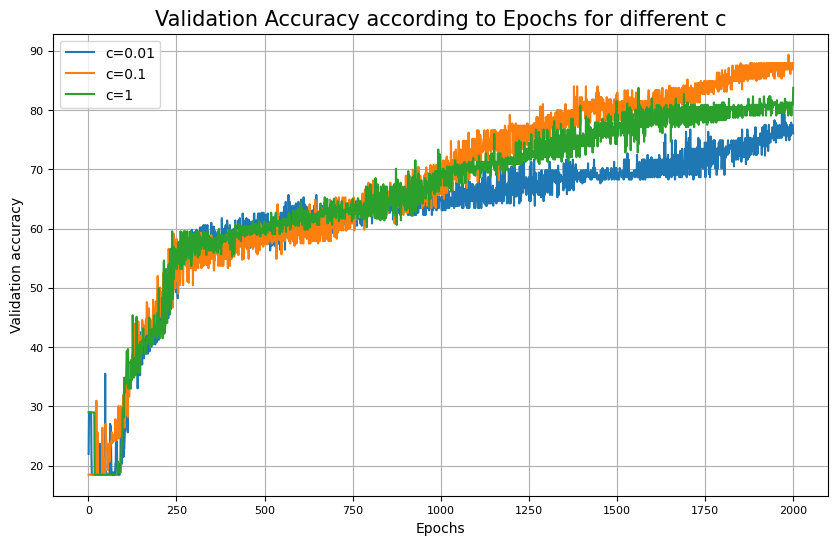

The optimal c is 0.1.


In [183]:
max_num_epochs = 2000
max_patience = 150

c_values = [0.01, 0.1, 1]
val_accuracy_history = []
val_scores = []

plt.figure(figsize=(10, 6))

for c in c_values:
    print(f'For c={c}')

    # Augmented data
    X_balanced, y_balanced = augmented_data(X_imb, y_imb, X_depleted_class_3, y_depleted_class_3, c)

    # Split
    split_rate = 0.75
    np.random.seed(0)
    split_indices = np.random.choice(np.arange(X_balanced.shape[0]), size=int(split_rate * X_balanced.shape[0]), replace=False)

    X_train_balanced = X_balanced[split_indices]
    y_train_balanced = y_balanced[split_indices]

    val_split_indices = list(set(np.arange(X_balanced.shape[0])) - set(split_indices))
    X_val_balanced = X_balanced[val_split_indices]
    y_val_balanced = y_balanced[val_split_indices]

    # Model
    model_balanced, criterion_balanced, optimiser_balanced = get_model(X_train_balanced, classes)

    # Numpy arrays to PyTorch tensors
    X_train_balanced_tensor = (torch.tensor(X_train_balanced, dtype=torch.float32)).unsqueeze(1)
    y_train_balanced_tensor = torch.tensor(y_train_balanced)
    X_val_balanced_tensor = (torch.tensor(X_val_balanced, dtype=torch.float32)).unsqueeze(1)
    y_val_balanced_tensor = torch.tensor(y_val_balanced)

    # Creating training and validation datasets
    train_dataset_balanced = TensorDataset(X_train_balanced_tensor, y_train_balanced_tensor.squeeze())
    val_dataset_balanced = TensorDataset(X_val_balanced_tensor, y_val_balanced_tensor.squeeze())

    # Creating corresponding DataLoaders
    train_balanced_loader = DataLoader(train_dataset_balanced, batch_size=128, shuffle=True)
    val_balanced_loader = DataLoader(val_dataset_balanced, batch_size=128, shuffle=False)

    # Training
    history_c = training_loop(model_balanced, criterion_balanced, optimiser_balanced, train_balanced_loader, val_balanced_loader, max_num_epochs, max_patience)
    val_accuracy_history.append(history_c['validation_accuracy'])
    val_scores.append(history_c['validation_accuracy'][-1])
    plt.plot(range(1, len(val_accuracy_history[-1]) + 1), val_accuracy_history[-1], label=f'c={c}')


plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('Validation Accuracy according to Epochs for different c')
plt.legend()
plt.grid()
plt.show()

c_opti_index = np.argmax(val_scores)
c_opti = c_values[c_opti_index]

print(f'The optimal c is {c_opti}.')

Using the obtained optimal $c$ coefficient, we re-train the data augmented CNN on the training set and evaluate the classification accuracy on the test set.

In [192]:
# Augmented data
X_balanced, y_balanced = augmented_data(X_imb, y_imb, X_depleted_class_3, y_depleted_class_3, c_opti)

# Split
split_rate = 0.75
np.random.seed(0)
split_indices = np.random.choice(np.arange(X_balanced.shape[0]), size=int(split_rate * X_balanced.shape[0]), replace=False)

X_train_balanced = X_balanced[split_indices]
y_train_balanced = y_balanced[split_indices]

val_split_indices = list(set(np.arange(X_balanced.shape[0])) - set(split_indices))
X_val_balanced = X_balanced[val_split_indices]
y_val_balanced = y_balanced[val_split_indices]

# Model
model_balanced, criterion_balanced, optimiser_balanced = get_model(X_train_balanced, classes)

# Numpy arrays to PyTorch tensors
X_train_balanced_tensor = (torch.tensor(X_train_balanced, dtype=torch.float32)).unsqueeze(1)
y_train_balanced_tensor = torch.tensor(y_train_balanced)
X_val_balanced_tensor = (torch.tensor(X_val_balanced, dtype=torch.float32)).unsqueeze(1)
y_val_balanced_tensor = torch.tensor(y_val_balanced)

# Creating training and validation datasets
train_dataset_balanced = TensorDataset(X_train_balanced_tensor, y_train_balanced_tensor.squeeze())
val_dataset_balanced = TensorDataset(X_val_balanced_tensor, y_val_balanced_tensor.squeeze())

# Creating corresponding DataLoaders
train_balanced_loader = DataLoader(train_dataset_balanced, batch_size=128, shuffle=True)
val_balanced_loader = DataLoader(val_dataset_balanced, batch_size=128, shuffle=False)

# Training
history_balanced = training_loop(model_balanced, criterion_balanced, optimiser_balanced, train_balanced_loader, val_balanced_loader, max_num_epochs, max_patience)

Shape after second convolution: (28,28)
Shape after max-pool: (14,14)
Shape after second convolution: (10,10)
Shape after flattening: 800


  0%|          | 0/2000 [00:00<?, ?it/s]

We plot the learning curves:

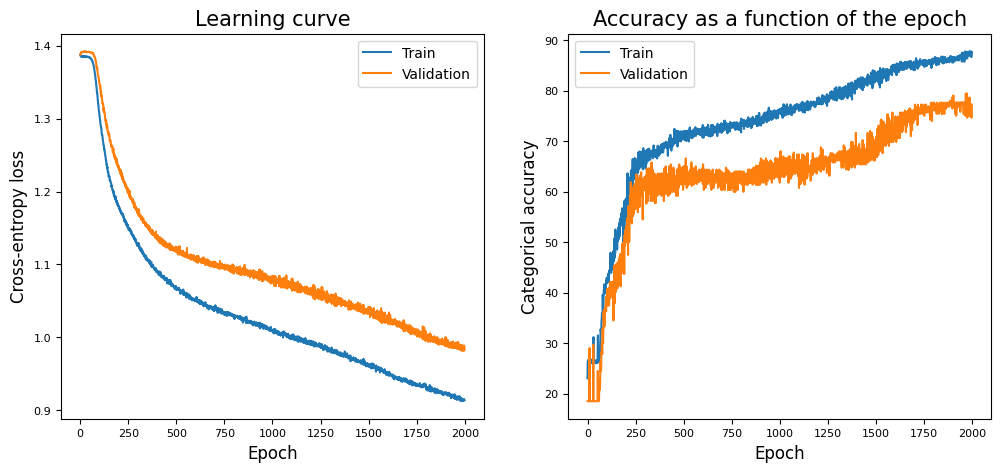

The training accuracy is: 87.53829656862744
The validation accuracy is: 77.24330357142857


In [193]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_balanced['training_loss'], label='Train')
plt.plot(history_balanced['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_balanced['training_accuracy'], label='Train')
plt.plot(history_balanced['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

print('The training accuracy is:', history_balanced['training_accuracy'][-1])
print('The validation accuracy is:', history_balanced['validation_accuracy'][-1])

**Analysis:** Here again, we observe a significant improvement in the model's performance after applying the data augmentation strategy. The training convergence for both the training and validation sets is much more reasonable and even tends to be similar, or even better, to that in _Task 1.1_. The final cross-entropy losses are close to 0.9 and 1 for training and validation sets, respectively, which is reasonable. Additionaly, the accuracies around 88% and 77% for training and validation sets, respectively, are much more acceptable.

In [196]:
# Get the model predictions on the test set
preds_balanced = model_balanced(X_test_tensor).detach().numpy()
preds_class_balanced = np.argmax(preds_balanced, axis=1)

# Compute accuracy of the model on the set
accuracy_balanced = (preds_class_balanced == y_test).sum() / len(y_test)

print('Truth: ', y_test)
print('Preds: ', preds_class_balanced)
print(f'\nAccuracy on Test set: {100*accuracy_balanced}%')

Truth:  [3 3 3 3 1 1 2 2 3 2 0 1 0 1 2 3 0 2 0 3 0 1 1 3 1 2 2 1 0 0 2 0]
Preds:  [3 3 3 3 1 1 2 2 3 2 0 1 1 1 2 3 0 2 0 3 0 1 1 3 1 2 2 1 0 1 2 0]

Accuracy on Test set: 93.75%


**Analysis:** Once again, we observe a significant improvement in the model's performance after applying the data augmentation strategy. An accuracy score of 93.8% is way more acceptable. It suggests that our data augmented model generalises very well to unseen data. The data augmentation stratety appears to be a reasonable strategy.

In [197]:
data_strategies_accuracy = pd.DataFrame({'Strategy' : ['Imbalanced Data','Reweighted strat', 'Data Augmentation strat'],
                        'Test accuracy' : [accuracy_imb, accuracy_weighted, accuracy_balanced]})

print(data_strategies_accuracy.to_string(index=False))

               Strategy  Test accuracy
        Imbalanced Data        0.59375
       Reweighted strat        0.84375
Data Augmentation strat        0.93750


**Conclusion:** Finally, we observe that, while both strategies appears to be effective, the second one with data augmentation tends to be the best one. By using this strategy, we passed from a test accuracy of 59.4% for the imbalanced data, to an almost perfect accuracy of 93.8%. Nonetheless, the improvement in the accuracy with the first reweighted strategy is still a lot significant and would be acceptable.



---



<a name="task-2"></a>

# (2) Task 2: Dimensionality Reduction: PCA vs ISOMAP [(index)](#index-task-2)

In this task, we will work with the embeddings of the star images. These embeddings are 180-dimensional vectors (one for each star), which have been obtained from a deep learning model that captures complex pixel relationships informative about the star class. Here, we will explore dimensionality reduction of these embeddings through two techniques: PCA and an algorithm inspired by Isomap.

We load the data:

In [123]:
X = np.load('star_embeddings_train.npy')

In [124]:
def standardise(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    Xbar: Standardised data.
    """

    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std==0] = 1.
    Xbar = (X - mu) / std

    return Xbar

In [125]:
value_to_type = {0 : 'O5V', 1: 'A0V', 2 : 'F5V', 3 : 'M5V'}

colors_dict = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
color_type = [colors_dict[i] for i in y]

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

We perform Principal Component Analysis (PCA) of the embedding vectors, following the standard PCA algorithm with data standardisation:
1. Compute the covariance matrix  $\mathbf C$.
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top$. The matrix $\mathbf{V}$ is composed of the eigenvectors of matrix $\mathbf{C}$ as its columns, while $\mathbf{L}$ is a diagonal matrix with the eigenvalues of $\mathbf{C}$ as its diagonal elements.
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top eigenvectors.

In [126]:
X_norm = standardise(X)

In [127]:
def covariance_matrix(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.

    Returns:
    C: Computes the data covariance matrix.
    """

    return np.dot(X.T, X) / len(X)


def pca_function(X, k):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.
    """

    # Computing the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which='LM', return_eigenvectors=True)

    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index]

    # Projecting the data onto the directions of eigenvectors
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

First of all, we set a reasonably large $k=100$ and analyse what fraction of the overall variance is explained by the components. Then, we find the number of components that allows us to explain at least 80% of the total variance.

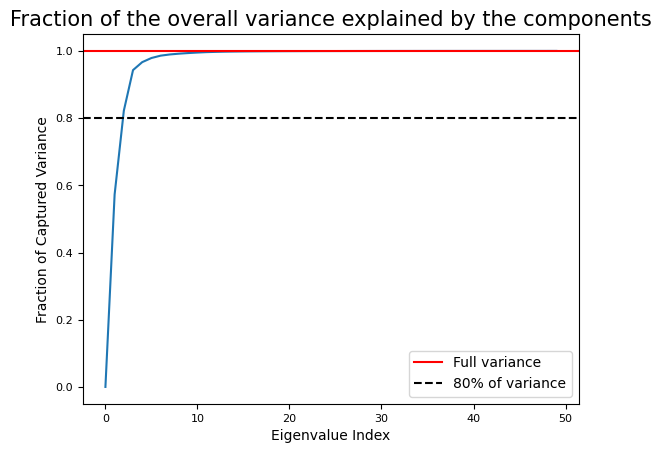

The optimal k is: 2.


In [128]:
k = 50

C = covariance_matrix(X_norm)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = [abs(all_eigenvalues[:j].sum()) / total_variance for j in range(k)]

plt.plot(np.arange(k), explained_variances)
plt.axhline(y = 1, color = 'r', linestyle = '-', label='Full variance')
plt.axhline(y = 0.8, color = 'k', linestyle = '--', label='80% of variance')
plt.title('Fraction of the overall variance explained by the components')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Fraction of Captured Variance')
plt.legend()
plt.show()

opt_k = np.argmax(np.array(explained_variances) >= 0.8)
print(f'The optimal k is: {opt_k}.')

From the result above, we found that the optimal $k$ is $k=2$, meaning that the first two principal components would be enough to describe the principal significant trends in the data.

We now aim to plot the data points in a 2D space based on their projections onto eigenvectors 1 and 2 (`PC1` and `PC2`).

In [129]:
X_pca, eigenvectors, eigenvalues = pca_function(X_norm, opt_k)

Text(0.5, 0.98, 'Embeddings in the 2D space of the first two principal components of PCA')

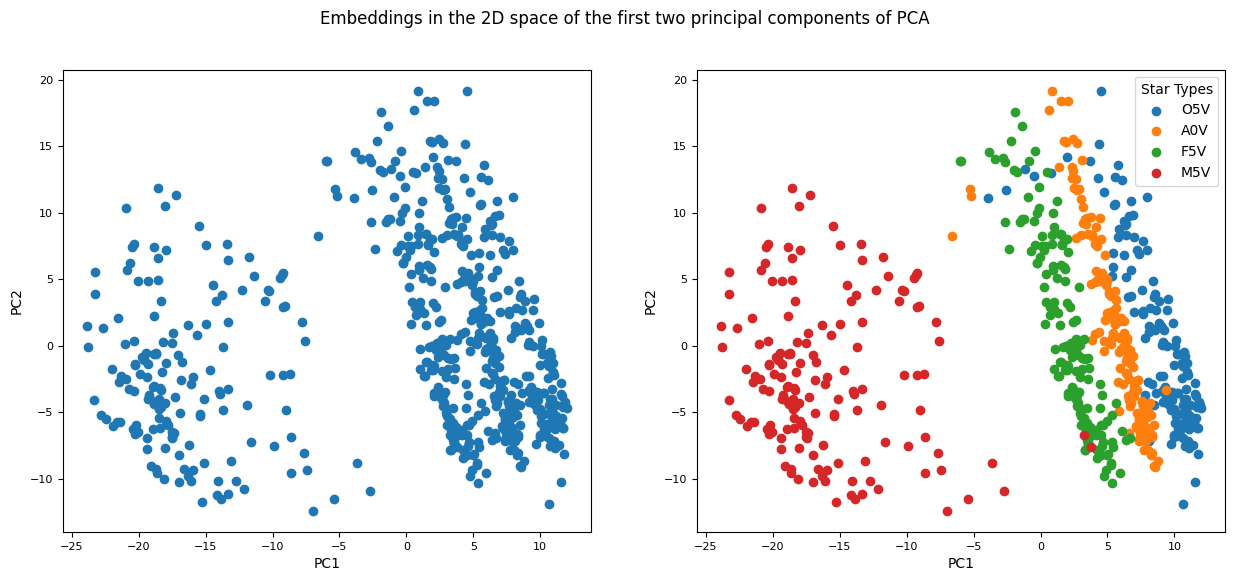

In [130]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')

fig.add_subplot(122)
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label=value_to_type[0])
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label=value_to_type[1])
plt.scatter(X_pca[y==2, 0], X_pca[y==2, 1], label=value_to_type[2])
plt.scatter(X_pca[y==3, 0], X_pca[y==3, 1], label=value_to_type[3])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title = 'Star Types')
fig.suptitle('Embeddings in the 2D space of the first two principal components of PCA')

At first sight, we observe that PCA appears to effectively cluster the data. First of all, the star type 'M5V' has been well identified and seperated from the other star types. Secondly, for the other star types 'O5V, A0V and F5V', the distinction is less obvious, but still present.

Nevertheless, we observe, especially for the three star types 'O5V, A0V and F5V', that the distances between clusters are significantly smaller than the within distances in each cluster. Recall that an ideal clustering model would show significant seperation between clusters, with elements within in each cluster being closely grouped. In other words, the distances between clusters is much higher >> than the within distances in each cluster. Knowing this, we would tend to say that our PCA may not be achieving optimal performance in clustering the data.

In addition, we notice that the variance, on the PC1-axis, in the 'M5V' type is much larger than for the other types. This high variance in the 'M5V' type would suggest a potential diversity within this star type, whereas the other star types show more uniformity within their type.

Nonetheless, this result still demonstrates that star type 'M5V' tends to be more easily distinguished from the other star types.

We evaluate more precisely the model's performance to cluster the data, using the Davies-Bouldin Index.

In [131]:
def compute_centroids(k, X, labels):
    """
    Compute the centroids of the clustered points X.

    Args:
        k (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).

    Returns:
        (np.ndarray): the centroids of the k clusters, with shape (k, p).
    """

    _, p = X.shape
    centroids = np.zeros((k, p))

    for label in range(k):
        cluster_X_l = X[labels == label]
        centroids[label] = cluster_X_l.mean(axis=0)

    return centroids

In [132]:
def compute_within_distance(centroid, X):
    """
    Compute the within-cluster mean distance.

    Args:
        centroid (np.ndarray): the centroid array, with shape (1, p).
        X (np.ndarray): the samples array of the cluster, with shape (m, p).

    Retruns:
        (float): the within-cluster mean distance.
    """

    cluster_se = np.sqrt(np.sum((X - centroid)**2, axis=1))

    return np.mean(cluster_se)

In [133]:
def compute_centroids_distance(centroids):
    """
    Compute the distances between clusters.

    Args:
        centroids (np.ndarray): the centroids array, with shape (1, p).

    Retruns:
        M (np.ndarray): the matrix of distances between clusters, with shape (k, k).
    """

    M = np.zeros((centroids.shape[0],centroids.shape[0]))

    for i in range(centroids.shape[0]):
        M[i, i] = 1
        for j in range(i+1, centroids.shape[0]):
            M[i, j] = np.sqrt(np.sum((centroids[i] - centroids[j])**2))
            M[j, i] = M[i, j]

    return M

In [134]:
def Davies_Bouldin(X, labels, C):
    """
    Compute the Davies Bouldin Index.

    Args:
        X (np.ndarray): data points, with shape (N, p).
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).
        C (np.ndarray): convariance matrix.

    Retruns:
        DBI (float): Davies Bouldin Index.
    """

    k = len(np.unique(labels))

    # Compute centroids
    centroids = compute_centroids(k, X, labels)

    # Compute S
    S_vect = np.array([compute_within_distance(centroid, X[y==i]) for i, centroid in enumerate(centroids)])
    S_mat = np.array([S_vect + S_alpha for S_alpha in S_vect])

    # Compute M
    M = compute_centroids_distance(centroids)

    # Compute F
    F = (S_mat / M)

    # Compute max for each alpha in F
    max_vect = np.array([np.max([F[i,j] for j in range(F.shape[1]) if i!=j]) for i in range(F.shape[0])])

    return np.mean(max_vect)

In [135]:
DB_pca = Davies_Bouldin(X_pca, y, C=4)
print(f'The Davies-Bouldin Index measure of clustering quality is {DB_pca:.2f}.')

The Davies-Bouldin Index measure of clustering quality is 2.85.


**Analysis:** A Davies-Bouldin index of 2.85 suggests that the clustering performed by the PCA is good. A perfect Davies-Bouldin index would be close to 0, while an ideal BD index is typically between 0 and 1. Therefore, with a DB index of 2.85, we understand that our model is far from being perfect, but certainly not inadequate.  
This index could be explained by the previous above observations: 'the distances between clusters are significantly smaller than the within distances in each cluster', which is the opposite of the characteristics of an ideal clustering model.



---



<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

In [136]:
X = np.load('star_embeddings_train.npy')

We build the cosine distance matrix $D$, where:
$$
D_{ij} = 1 - \frac{X_i \cdot X_j}{||X_i||_2||X_j||_2}
$$

In [137]:
def cosine_matrix(X):
  """
  Compute the cosine distance matrix.

  Args:
      X (np.ndarray): data points, with shape (N, p).

  Retruns:
      D (np.ndarray): cosine distance matrix.
  """

  num_matrix = X @ X.T
  denum_matrix = np.outer(np.sqrt(np.diag(num_matrix)), np.sqrt(np.diag(num_matrix)))

  return 1 - num_matrix / denum_matrix

We now construct the adjacency matrix $A$ of the $k$-Nearest Neighbour ($k$NN) graph for k=9, where two nodes $i$ and $j$ are connected with an undirected edge with weight $D_{ij}$ if $X_i$ is within the $k$-nearest neighbours of $X_j$ or if $X_j$ is within the $k$-nearest neighbours, according to cosine distance, of $X_i$.

In [138]:
def adjacency_matrix(X, k=9):
  """
  Construct the adjacency matrix of the k-Nearest Neighbour, according to cosine distance, (kNN) graph.

  Args:
      X (np.ndarray): data points, with shape (N, p).
      k (int): number of nearest neighbours according to cosine distance.

  Retruns:
      A (np.ndarray): adjacency matrix.
  """

  D = cosine_matrix(X)

  A = np.zeros((X.shape[0], X.shape[0]))

  for i in range(X.shape[0]):
    neighbours_indices = np.argsort(D[i])[1: k+1] # Remove the current_node from its neighbours
    for j in neighbours_indices:
      A[i, j] = D[i, j]
      A[j, i] = A[i, j]

  return A

We then focus our analysis on the spectrum of the normalised graph Laplacian $L_\text{sym}$, which is given by:

$$L_\text{sym}=D^{-1/2} L D^{-1/2},$$

where $L=D-A$ is the combinatorial Laplacian, $D$ the diagonal degree matrix and $A$ the adjacency matrix.

In [139]:
A = adjacency_matrix(X, k=9)

# Define degree vector
d = np.sum(A, axis=0)

# Define diagonal degree matrix
D = np.diag(d)

# Compute combinatorial Laplacian
L = D - A

# Compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(d))

# Compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv

We check that everything is, so far, well implemented, knowing that the square-root of the degree vector should be an eigenvector of $L_s$ with eigenvalue 0

In [140]:
np.allclose(L_s @ np.sqrt(d),np.zeros(X.shape[0]))

True

We compute the full spectrum of $L_\text{sym}$, using the fact that it is a real symmetric matrix and sort the eigenvalues (and corresponding eigenvectors) in ascending order.

In [141]:
# Compute eigen decomposition using the fact that L_s is a real symmetric matrix
eigenvals, eigenvecs = np.linalg.eigh(L_s)

# Sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]
eigenvals = np.sort(eigenvals)

We use the second (Fiedler) eigenvector $\boldsymbol{v}_2$ and third eigengenvector $\boldsymbol{v}_3$ to visualise the network. Using these two Laplacian eigenvectors as $\boldsymbol{x}$ and $\boldsymbol{y}$ coordinates of the nodes gives us a a spectral embedding. We improve the visualisation when normalising the coordinates such that $\boldsymbol{x}=D^{-1/2}\boldsymbol{v}_2$ and $\boldsymbol{y}=D^{-1/2}\boldsymbol{v}_3$.

In [142]:
# Get second (Fiedler) and third eigenvectors
v2 = eigenvecs[1]
v3 = eigenvecs[2]

# Normalise coordinates
x_cord = D_sqrt_inv @ v2
y_cord = D_sqrt_inv @ v3

We plot the graph by drawing lines between the embeddings of two connected nodes. Additionally, we scale the node size dependent on the degree.

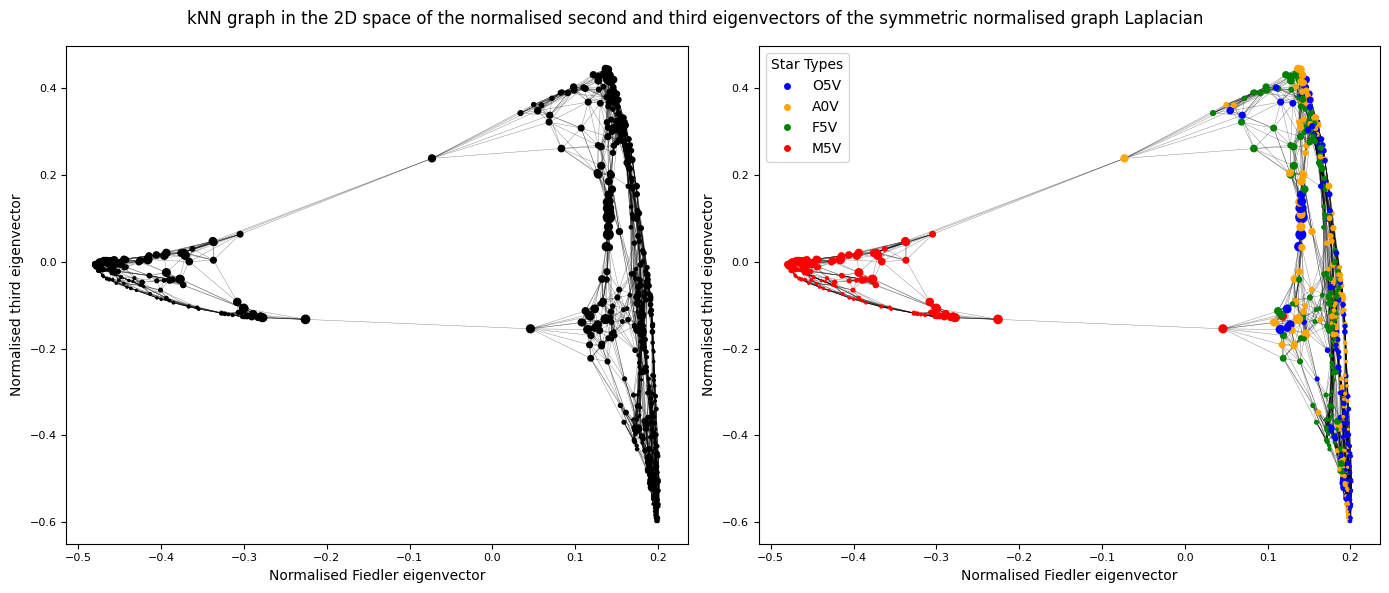

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

# Plot edges
for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        if A[i,j] > 0:
            ax[0].plot([x_cord[i],x_cord[j]], [y_cord[i],y_cord[j]], color="black", alpha=0.5, linewidth=0.3)

# Plot nodes with respective colors
scatter = ax[0].scatter(x_cord, y_cord, s=400*d, c='black', zorder=10)


# Plot edges
for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        if A[i,j] > 0:
            ax[1].plot([x_cord[i],x_cord[j]], [y_cord[i],y_cord[j]], color="black", alpha=0.5, linewidth=0.3)

# Plot nodes with respective colors
scatter = ax[1].scatter(x_cord, y_cord, s=400*d, c=color_type, zorder=10)

# Create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors_dict[value]) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Star Types')

# Set labels
ax[0].set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector")
ax[1].set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector")
fig.suptitle('kNN graph in the 2D space of the normalised second and third eigenvectors of the symmetric normalised graph Laplacian')
plt.show()

**Analysis:** First of all, as observed on the colored graph, the star type 'M5V' has been well identified and seperated from the other star types. Secondly, for the other star types 'O5V, A0V and F5V', the distinction is much less obvious.

The clustering shows significant weaknesses, especially for the three star types 'O5V, A0V and F5V'. Indeed, it is very hard to distinguish between the three types as they are all very close to each other, even often overlapping. More generally, we observe that the distances between clusters are significantly smaller than the within distances in each cluster. Hence, we would tend to say that our clustering may not be achieving optimal performance.

Nonetheless, this result still demonstrates (as seen for PCA) that star type 'M5V' tends to be more easily distinguished from the other star types, whereas the distinction for the three other star types tends to be more difficult to define.



---



<a name="task-22"></a>

## (2.3) [(index)](#index-task-23)

The second step in the Isomap-like algorithm is to compute distances between nodes in the graph constructed in _Task 2.2_. In particular, we compute the resistance distance matrix $R$, where $R_{ij}$ is given by:
$$
R_{ij}:= Γ_{ii}+ Γ_{jj} - 2Γ_{ij},
$$

$$
Γ = (L - \frac{1}{N}\mathbf{1}\mathbf{1}^T)^+,
$$

where + denotes the Moore–Penrose inverse; L is the combinatorial graph Laplacian; N is the number of nodes; and $\mathbf{1}$ is the N-dimensional vector of ones.

In [144]:
# Compute Gamma matrix
Gamma_matrix = np.linalg.pinv(L - 1/(X.shape[0]))

# Compute R
R = np.array([np.diag(Gamma_matrix) + Gamma for Gamma in np.diag(Gamma_matrix)]) - 2*Gamma_matrix

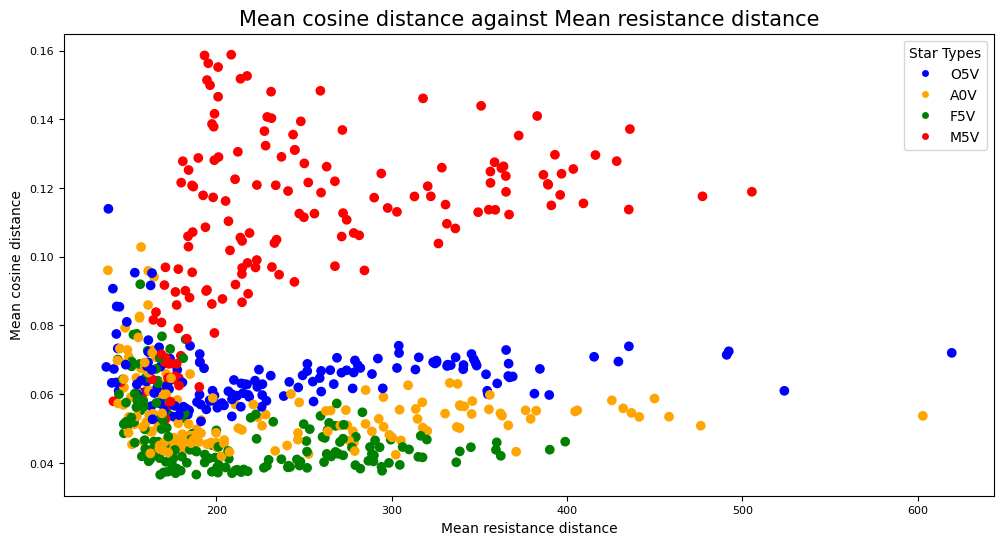

In [145]:
D = cosine_matrix(X)

fig = plt.figure(figsize=(12, 6))

plt.scatter(np.mean(R, axis=1), np.mean(D, axis=1), color=color_type)
plt.xlabel('Mean resistance distance')
plt.ylabel('Mean cosine distance')
plt.title('Mean cosine distance against Mean resistance distance')

types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors_dict[value]) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Star Types')

**Analysis:** The primary observation to make is, once again, the clear seperation between star type 'M5V' in red and the other star types. Indeed, 'M5V' stars tend to have a higher mean cosine distance compared to the other types, with a predominant range between 0.10 and 0.16, while the other types remain below 0.08. In fact, the variance is much larger for 'M5V' than for the other types.  
Furthermore, the other star types demonstrate similar mean cosine distances. We observe kind of an ascending order in the mean cosine distances: 'F5V', 'A0V', and then 'O5V'. By interpreting the cosine distance, and distance metrics in graphs in general, we understand that 'M5V' stars tend to be further apart (or less similar) to the overall other star types, while 'F5V' stars would tend to be 'close to the overall stars', in other words, less special. Additionally, the high variance in 'M5V' mean cosine distances underscores a potential diversity within this star type, whereas the other star types show more uniformity within their type.

Next, let's look at the mean resistance distance. First of all, from Wikipedia, we have the definition: "In graph theory, the resistance distance between two vertices of a simple, connected graph, $G$, is equal to the resistance between two equivalent points on an electrical network, constructed so as to correspond to $G$, with each edge being replaced by a resistance of one ohm. It is a metric on graphs." Therefore, two nodes with a small resistance distance would be closely connected ('easy' to get from one node to the other). Conversely, two nodes with a high resistance distance would be less connected ('hard' to get from one node to the other).  
In our case, we are examining the mean resistance distance for each node with all other nodes. Hence, a node with a small mean resistance distance would be a star with close connections with other stars. Conversely, if its mean resistance is large, it suggests 'weak' connections.  
On the graph, we observe a concentration of 'F5V', 'A0V', and 'O5V' stars below a mean resistance distance of 200, whereas 'M5V' stars tend to be above this threshold. For larger mean resistance distances, the distribution of the four types appears to be more similar, without clear distinctions. Nevertheless, overall, 'M5V' stars seem to have larger mean resistance distances, indicating weaker connections with the other stars.

These observations are consistent with our previous findings during our analysis.

Finally, we obtain a 2D projection of the graph distances, by computing the centred distance matrix $\tau$ from the resistance distance matrix $R$ as given by the formula:

$$
\tau := -HSH/2,
$$

$$
H = I - \frac{1}{N}\mathbf{1}\mathbf{1}^T,
$$

where $S$ is given by $S_{ij}=R_{ij}^2$ and $I$ is the $N\times N$ identity matrix.

In [146]:
H = np.identity(X.shape[0]) - (1 / (X.shape[0]))
S = R**2
tau_matrix = - (H @ S @ H) / 2

We then find the eigenvectors of $\tau$ and visualise the embeddings in the 2D space of the top two eigenvectors of $\tau$.

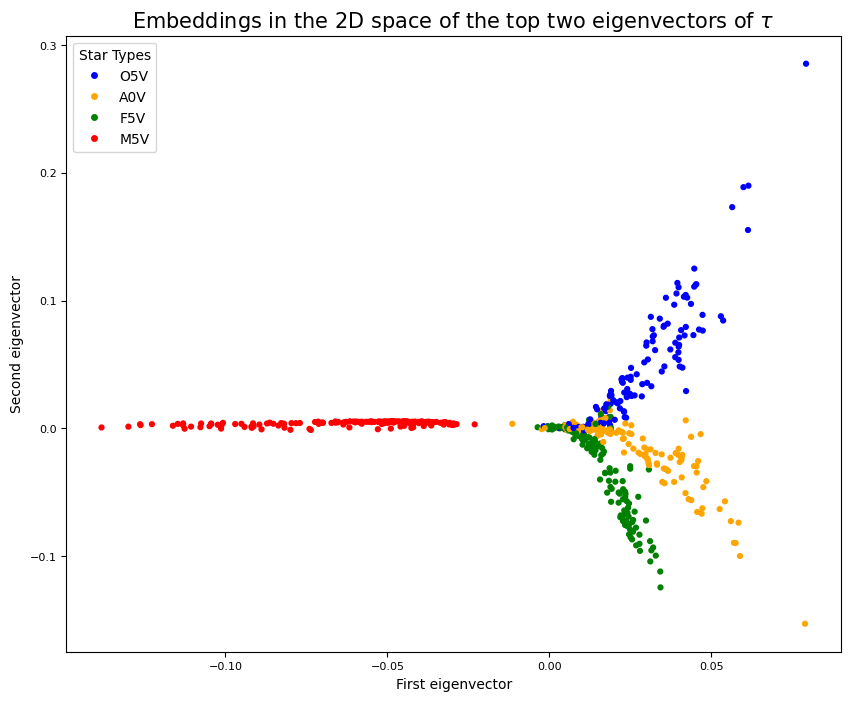

In [147]:
# Compute eigen decomposition using the fact that tau is a real symmetric matrix
eigenvals_tau, eigenvecs_tau = np.linalg.eigh(tau_matrix)


# Sort eigenvalues and corresponding eigenvector
indices = np.argsort(eigenvals_tau)[::-1]
eigenvecs_tau = eigenvecs_tau[:, indices]
eigenvals_tau = eigenvals_tau[indices]

# Plot
fig = plt.figure(figsize=(10, 8))
plt.scatter(eigenvecs_tau[:, 0], eigenvecs_tau[:, 1], c=color_type, s=12)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.title(r'Embeddings in the 2D space of the top two eigenvectors of $\tau$')

types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors_dict[value]) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Star Types')

**Analysis:** The primary observation to make is, the clear seperation of the four star types. We notice that, once again, the 'M5V' stars have been well identified. Furthermore, compared to PCA, here, the three other star types have also been pretty well identified, especially when looking at the 'tails' of each cluster. However, we notice a concentration of points near (0, 0), where the three types overlap a lot.  
Additionally, we also notice a higher variance, on the first eigenvector axis, for the 'M5V' stars, suggesting a potential diversity within this star type, whereas the other star types show more uniformity within their type, again according to the first eigenvector axis.  
A characteristic of this method that we can observe is that while 'M5V' stars tend to have a 0 coordinate for the second eigenvector, the other types tend to have a 0 coordinate on the first eigenvector. It looks like the first eigenvector has been able to identity the star type that differs the most from the other, and then the second eigenvector the second most explicit distinction, etc.  
Nonetheless, once again, we observe that the distances between clusters are much smaller than the within-cluster distances. Hence, despite the four star types appearing to be better identified here than with PCA, the overlapping near (0, 0) and the clusters distances being smaller than the within-cluster distances may decrease the model's performance.

We evaluate more precisely the model's performance to cluster the data, using the Davies-Bouldin Index and compare it to PCA.

In [148]:
coords_matrix = np.vstack((eigenvecs_tau[:, 0], eigenvecs_tau[:, 1])).T
DB = Davies_Bouldin(coords_matrix, y, C=4)

print(f'The Davies-Bouldin Index measure of clustering quality is {DB:.3f}.')

The Davies-Bouldin Index measure of clustering quality is 1.937.


In [149]:
DB_indices = pd.DataFrame({'Method' : ['PCA', '\'ISOMAP\''],
                        'DB_index' : ["{:.3f}".format(DB_pca), "{:.3f}".format(DB)]})

print(DB_indices.to_string(index=False))

  Method DB_index
     PCA    2.853
'ISOMAP'    1.937


**Analysis:** As expected, the Davies-Bouldin index of the Isomap-like algorithm is lower than that of the PCA, indicating that it performed better than PCA in clustering the data.  Indeed, we observed that the Isomap-like algorithm performed better in 'clearly' identifying all four different star types, while PCA only managed to 'clearly' identify the 'M5V' stars, with a much less accurate clustering of the three remaining types.

Nonetheless, it is notable than even with the Isomap-like algorithm, the distances between clusters tend to be lower than the within-cluster distances. As explained before, it underlines a non-optimal clustering, and would explained the somewhat pretty high DB index of 1.9 (an optimal clustering typically has a DB index between 0 and 1, ideally close to 0).



---

